In [4]:
import pandas as pd
import numpy as np
import itertools

from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, confusion_matrix, classification_report, auc, roc_curve
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, cross_val_score, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import Perceptron
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier

from scipy.stats import beta

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from imblearn.over_sampling import SMOTE, RandomOverSampler, BorderlineSMOTE, ADASYN
from imblearn.pipeline import Pipeline as IMBPipeline

import missingno as msno

import seaborn as sns

import matplotlib.pyplot as plt
import warnings

from joblib import dump, load

warnings.filterwarnings('ignore')

# A Brief Introduction

## Project Overview
In this project, we aim to leverage machine learning techniques for the classification of astronomical objects, using data from the Sloan Digital Sky Survey (SDSS). The primary goal is to categorize these objects into three distinct classes: stars, galaxies, or quasars. This classification is vital for astrophysical research and offers insights into the composition and dynamics of the universe.

## Dataset Description
The dataset is comprised of 100,000 observations from the SDSS, each detailed with 17 feature columns and 1 class column. These features encompass various astronomical and observational data, while the class column labels the object as either a star, galaxy, or quasar.

## Feature Descriptions and Potential Usefulness

1. **obj_ID (Object Identifier):** 
   - Unique identifier for each object in the image catalog.
   - Important for data tracking and integrity, though not directly used in classification.

2. **Alpha (Right Ascension) and Delta (Declination Angle):** 
   - Specifies the object's sky position.
   - Useful for identifying object clusters in specific sky regions.

3. **Photometric System Filters (u, g, r, i, z):** 
   - Measures light in ultraviolet, green, red, near-infrared, and infrared wavelengths.
   - Crucial for distinguishing object types based on their light emission patterns.

4. **run_ID, rereun_ID, cam_col, field_ID:** 
   - Details about the observation run, image processing, and field identification.
   - Helps identify systematic errors or biases in data collection.

5. **spec_obj_ID (Spectroscopic Object Identifier):** 
   - Unique ID for spectroscopically observed objects.
   - Links photometric and spectroscopic data for comprehensive analysis.

6. **Class (Galaxy, Star, Quasar):**
   - The target variable for classification
      -  Galaxies: Immense systems composed of stars, dust, and dark matter, spanning from millions to trillions of stars in various formations like spirals and ellipsoids.
      - Stars: Luminous plasma spheres, maintained by gravity, radiating energy from nuclear fusion within their cores.
      - Quasars (QSOs): Among the brightest objects in the universe, quasars are powered by supermassive black holes actively consuming surrounding material. This process emits prodigious energy across the electromagnetic spectrum, making quasars extraordinarily radiant and visible over great distances.

7. **Redshift:**
   - Indicates object distance and velocity through wavelength shift.
   - Key for differentiating between nearby stars and distant galaxies or quasars.

8. **Plate and fiber_ID:** 
   - Relates to the observation hardware.
   - Useful for identifying hardware-specific data biases.

9. **MJD (Modified Julian Date):**
   - The observation date.
   - Captures time-related changes in object visibility or properties.

## Goal
The project's primary objective is to develop an accurate machine learning model for classifying these astronomical objects. Each feature in the dataset provides unique insights into the objects' properties, aiding in the classification process.

# Loading, adding noise and checking the Dataset

In [103]:
path_df = "star_classification.csv"
df = pd.read_csv(path_df)

df.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [104]:
df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [106]:
def add_missing(col, amount):
    X = col.copy()
    size = amount if amount >= 1 else int(len(X) * amount)
    indexes = np.random.choice(len(X), size, replace = False )
    X[indexes] = np.nan
    return X

def add_missing_rows(df, amount):
    X = df.copy()
    rows, cols = X.shape
    size = amount if amount >= 1 else int(rows * amount)
    indexes = np.random.choice(rows, size, replace = False ) + 0.5
    for i in indexes:
        X.loc[i] = np.full((cols,),np.nan)
    X = X.sort_index().reset_index(drop=True)
    return X

In [107]:
df['run_ID'] = add_missing(df['run_ID'], 0.1)
df['field_ID'] = add_missing(df['field_ID'], 0.25)
df['MJD'] = add_missing(df['MJD'],0.05)
df['plate'] = add_missing(df['plate'], 0.6)
df['i'] = add_missing(df['i'],0.05)
df['r'] = add_missing(df['r'], 0.05)
df['delta'] = add_missing(df['delta'], 0.05)
df = add_missing_rows(df, 0.05)

<Axes: >

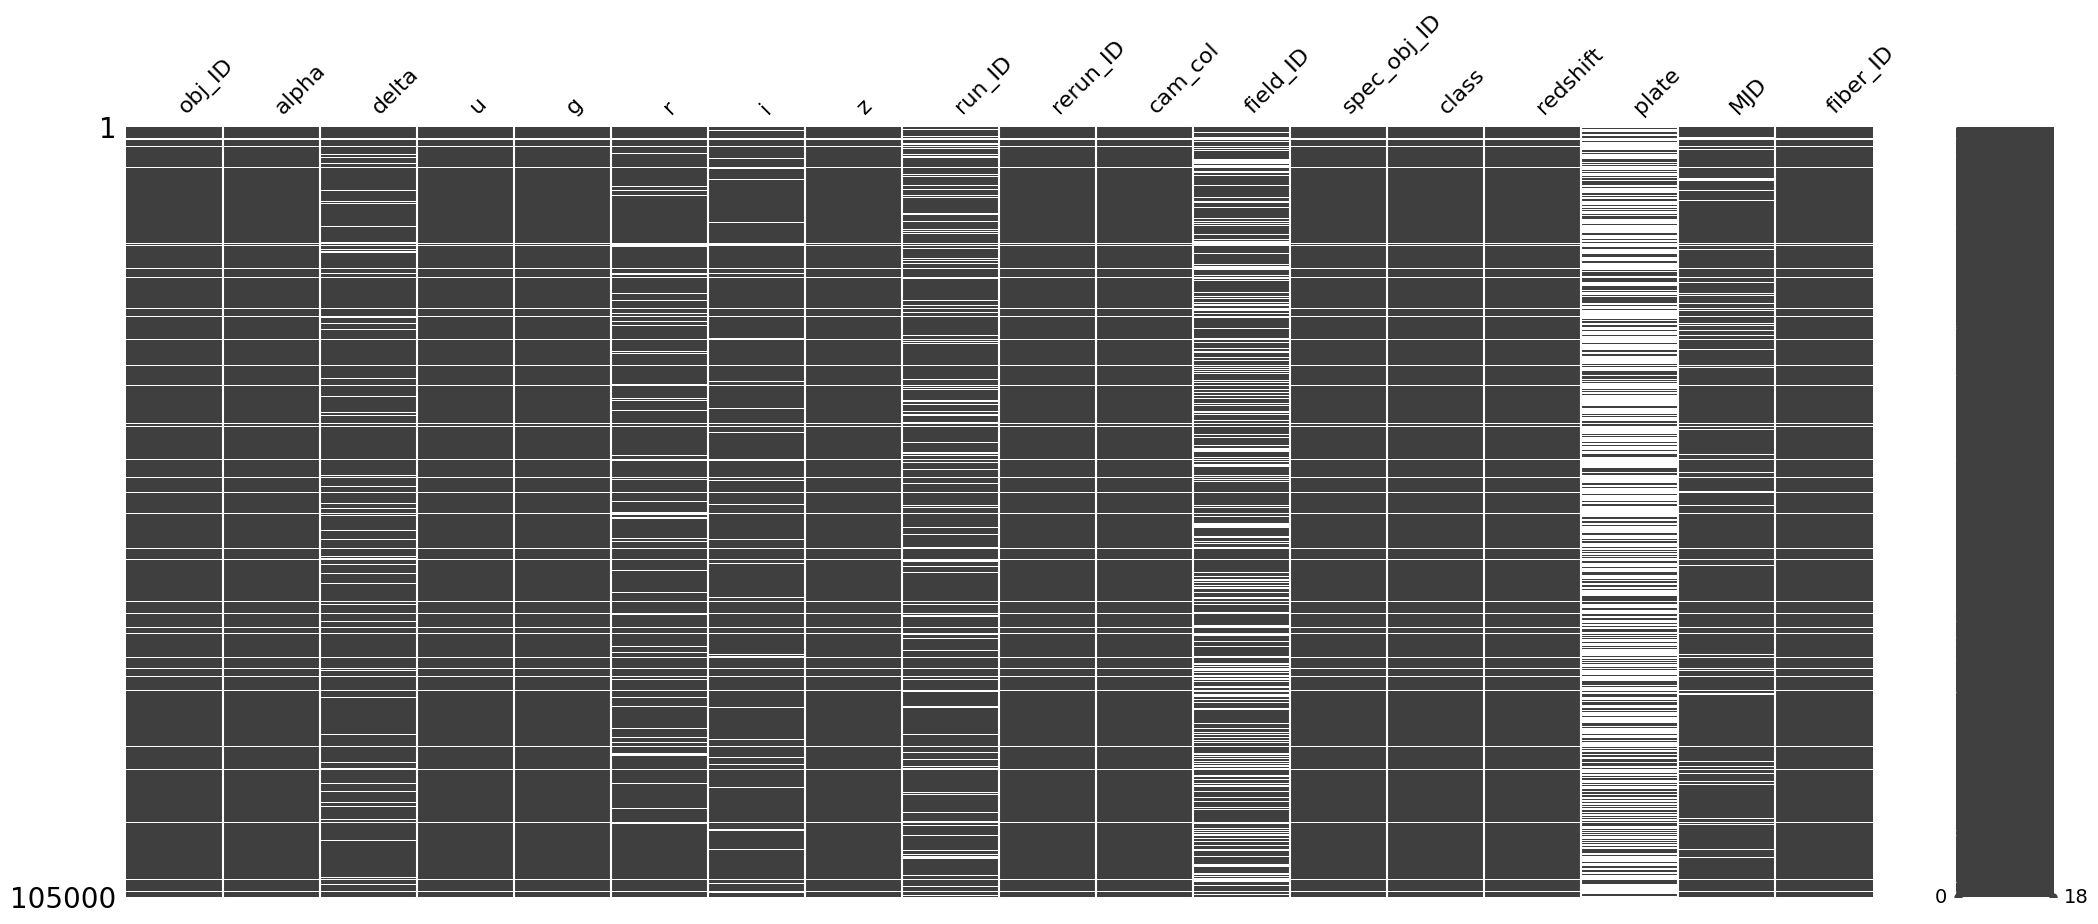

In [108]:
msno.matrix(df)

# Data Analysys
I will procede looking for insight and correlation in my data

## Melted Graph for Light Filter Distributions

**Visualization Technique:** The melted graph consolidates brightness readings from multiple photometric filters (u, g, r, i, z) into one visualization, with color-coding for each astronomical class.

**Significance:** This visualization is effective for comparing the emission characteristics of stars, galaxies, and quasars across different light spectra. It is particularly useful for detecting patterns that may influence the classification of these objects based on their photometric properties.

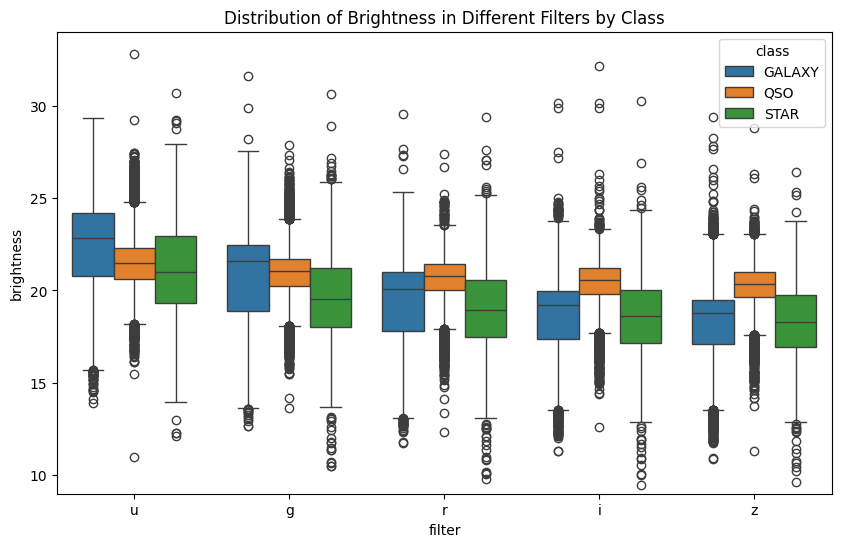

In [109]:
# Melting the DataFrame to have 'filter' and 'brightness' columns
melted_data = df.melt(id_vars='class',
                      value_vars=['u', 'g', 'r', 'i', 'z'],
                      var_name='filter',
                      value_name='brightness')

plt.figure(figsize=(10, 6))
sns.boxplot(x='filter', y='brightness', hue='class', data=melted_data)
plt.ylim(9, 34)
plt.title('Distribution of Brightness in Different Filters by Class')
plt.show()

## Scatter Plot for Celestial Coordinates

**Visualization Technique:** A scatter plot graphically represents the celestial coordinates of objects, with a color distinction for each class.

**Significance:** The scatter plot provides insights into the distribution of astronomical objects across the sky. It can indicate the existence of clusters or voids in the spatial arrangement of stars, galaxies, and quasars, which is crucial for understanding the large-scale structure of the cosmos.

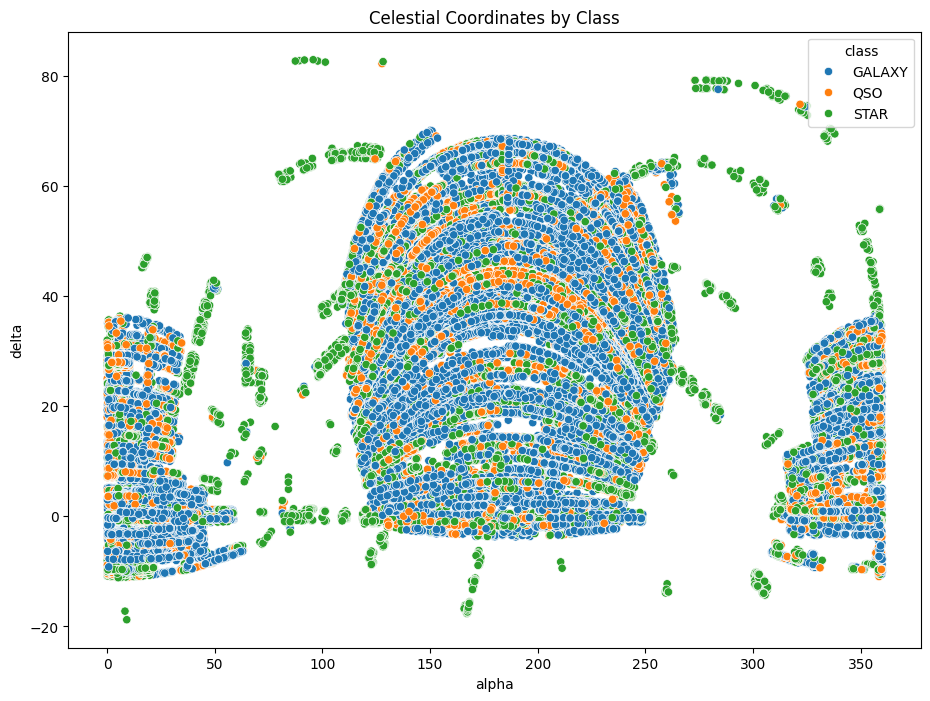

In [110]:
plt.figure(figsize=(11, 8))
sns.scatterplot(x='alpha', y='delta', hue='class', data=df)
plt.title('Celestial Coordinates by Class')
plt.show()

## Histograms for Redshift Distributions by Class
**What is redshift:** Redshift is a phenomenon where the light from celestial objects shifts towards the red end of the spectrum, indicating that the object is moving away from the observer. The redshift is higher for far-off objects because the universe is expanding; thus, the light from these objects has to travel through more expanding space, which stretches the light waves and increases the redshift.

**Visualization Technique:** Separate histograms depict the distribution of redshift values for galaxies, QSOs (quasars), and stars. This approach isolates the data for each class, enabling a focused analysis of redshift frequencies without inter-class overlap.

**Significance:** These histograms are crucial for understanding the distinct astronomical phenomena represented by each class. For galaxies, the histogram may show a wide range of redshift values, highlighting the diversity of galaxy distances and velocities. The QSO histogram likely features higher redshift values, reflecting their typically greater distances. The histogram for stars should cluster around lower redshift values, given their proximity within our galaxy, providing insight into local stellar populations.

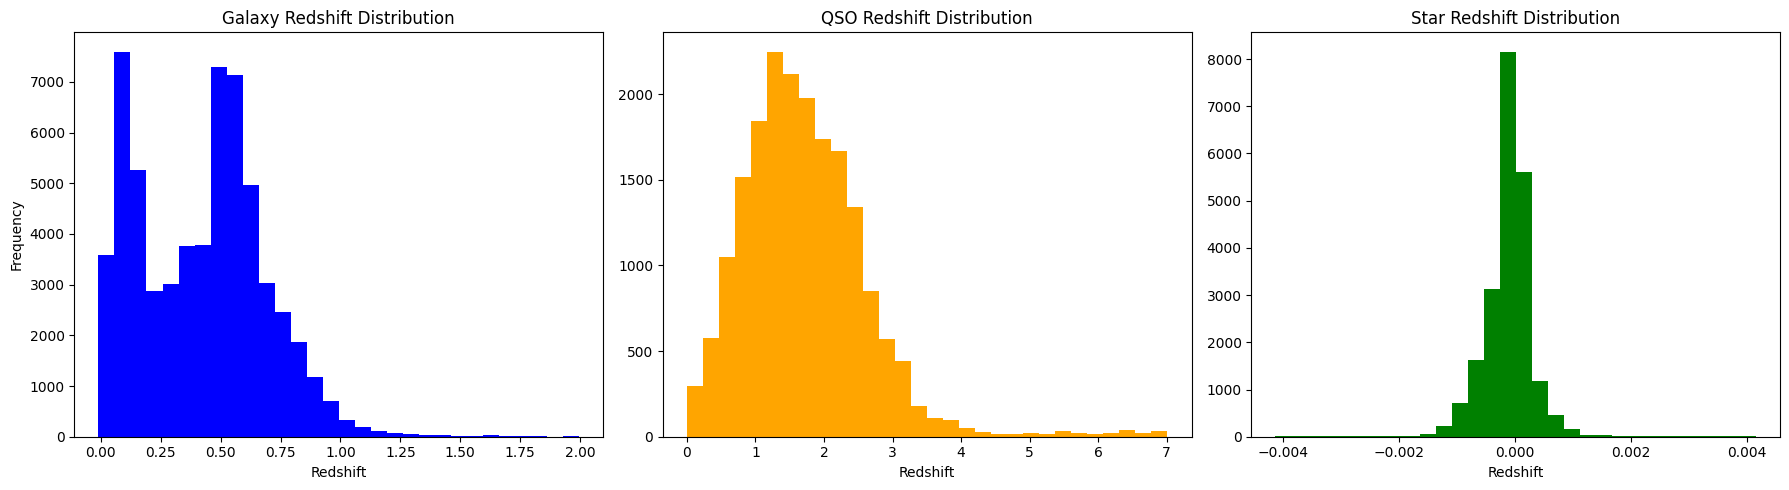

In [111]:

galaxies = df[df['class'] == 'GALAXY']['redshift']
qsos = df[df['class'] == 'QSO']['redshift']
stars = df[df['class'] == 'STAR']['redshift']

plt.figure(figsize=(18, 5))

# Plot for GALAXY
plt.subplot(1, 3, 1)
plt.hist(galaxies, bins=30, color='blue')
plt.title('Galaxy Redshift Distribution')
plt.xlabel('Redshift')
plt.ylabel('Frequency')

# Plot for QSO
plt.subplot(1, 3, 2)
plt.hist(qsos, bins=30, color='orange')
plt.title('QSO Redshift Distribution')
plt.xlabel('Redshift')

# Plot for STAR
plt.subplot(1, 3, 3)
plt.hist(stars, bins=30, color='green')
plt.title('Star Redshift Distribution')
plt.xlabel('Redshift')

plt.tight_layout()
plt.show()


## Class Imbalance
Another aspect of our dataset to consider is class imbalance, which can result in misclassification of minority classes in favor of majority one

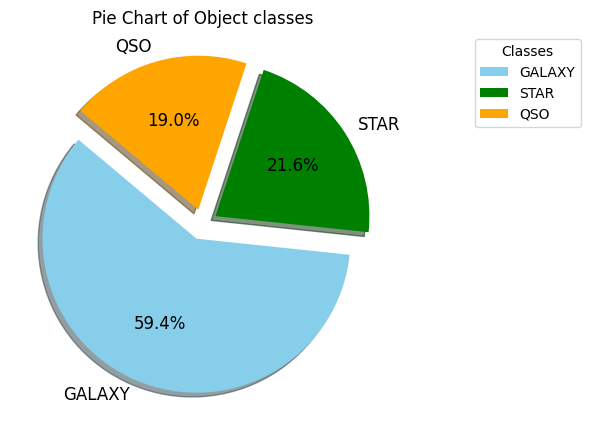

In [112]:
classes_count = df["class"].value_counts()

plt.figure(figsize=(7,5))

classes_count.plot(kind='pie',
                   explode=[0.1,0.1,0.1],
                   colors=['skyblue', 'green', 'orange'],
                   autopct='%1.1f%%', 
                   shadow=True,
                   startangle=140,
                   textprops={'fontsize': 12})

plt.legend(title='Classes', loc='upper right', bbox_to_anchor=(1, 0, 0.5, 1))

plt.title('Pie Chart of Object classes')
plt.ylabel('') 
plt.show()

We observe a prevalence of the galaxy samples, we will take this into account later with sampling techniques.

# Feature engineering
The columns 'obj_ID', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'plate', and 'fiber_ID' were dropped primarily because they contain a large number of unique identifiers, which, if one-hot encoded, would significantly increase the dimensionality of the dataset without providing meaningful predictive information for classifying astronomical objects. These columns mostly represent observational metadata rather than intrinsic properties of celestial objects, making them less relevant for the classification task.

In [113]:
columns_to_check = ['obj_ID', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'plate', 'fiber_ID']
unique_value_counts = {col: df[col].nunique() for col in columns_to_check}

unique_value_counts

{'obj_ID': 78053,
 'run_ID': 430,
 'rerun_ID': 1,
 'cam_col': 6,
 'field_ID': 851,
 'spec_obj_ID': 100000,
 'plate': 5953,
 'fiber_ID': 1000}

In [114]:
columns_to_drop = ['obj_ID','run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID','plate','fiber_ID']
df_dropped = df.drop(columns=columns_to_drop)

df_dropped.head()

,alpha,delta,u,g,r,i,z,class,redshift,MJD
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY,0.634794,56354.0
1,144.826101,NaN,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY,0.779136,58158.0
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY,0.644195,55592.0
3,338.741038,-0.402828,22.13682,23.77656,NaN,20.50454,19.25010,GALAXY,0.932346,58039.0
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY,0.116123,56187.0


I'll also drop the missing rows

In [115]:
df_dropped = df_dropped.dropna(how='all')
df_dropped

,alpha,delta,u,g,r,i,z,class,redshift,MJD
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY,0.634794,56354.0
1,144.826101,NaN,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY,0.779136,58158.0
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY,0.644195,55592.0
3,338.741038,-0.402828,22.13682,23.77656,NaN,20.50454,19.25010,GALAXY,0.932346,58039.0
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY,0.116123,56187.0
...,...,...,...,...,...,...,...,...,...,...
104995,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,GALAXY,0.000000,57749.0
104996,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,GALAXY,0.404895,56934.0
104997,224.587407,NaN,21.16916,19.26997,18.20428,17.69034,17.35221,GALAXY,0.143366,54535.0
104998,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,GALAXY,0.455040,56368.0


## Building a column transformer
The missing values are handled with a KNNimputer

The class feature is being transformed with a one-hot encoder only to visualize potential correlation in the correlation matrix below, the one-hot columns will then be removed and the target feature will remain as in the original dataframe

In [116]:
pipeline_numerical = Pipeline([
    ('imputer', KNNImputer()),
    ('scaler', StandardScaler())
])

# one hot encode the class label in order to build the correlation matrix
pipeline_categorical = Pipeline([
    ('hot', OneHotEncoder(drop=None, handle_unknown='ignore'))
])

# pass the class label without one hot encoding it
pass_through_pipeline = Pipeline([
    ('identity', 'passthrough')
])


final_transformation = ColumnTransformer(transformers=[
    ('numerical', pipeline_numerical, ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift', 'MJD']),
    ('categorical', pipeline_categorical, ['class']),
    ('pass', pass_through_pipeline, ['class']),
],
remainder='drop',
verbose_feature_names_out=False,
sparse_threshold=0
)

Here I'm trasforming the values with the columns transformer. I'm also creating a new dataframe to store this values in an easier to manage format for data visualization

In [117]:
#Applying the transformation
array_transformed = final_transformation.fit_transform(df_dropped)

# Storing the columns names
one_hot_feature_names = final_transformation.named_transformers_['categorical'].get_feature_names_out()
numerical_feature_names = ['alpha','delta','u', 'g', 'r', 'i', 'z', 'redshift', 'MJD']
all_feature_names = numerical_feature_names + list(one_hot_feature_names) + ['class']

##Creating a new df with scaled values
df_transformed = pd.DataFrame(array_transformed, columns=all_feature_names)
df_transformed.head()

,alpha,delta,u,g,r,i,z,redshift,MJD,class_GALAXY,class_QSO,class_STAR,class
0,-0.434604,0.431425,0.059755,0.054926,0.404349,0.045815,0.003937,0.079557,0.426313,1.0,0.0,0.0,GALAXY
1,-0.339921,0.288535,0.088045,0.072456,1.588349,1.189792,0.092835,0.277096,1.431266,1.0,0.0,0.0,GALAXY
2,-0.367251,0.590202,0.103327,0.067165,0.520482,0.150273,0.008808,0.092423,0.001826,1.0,0.0,0.0,GALAXY
3,1.669523,-1.260177,0.004921,0.10221,1.150714,0.810685,0.018321,0.48677,1.364975,1.0,0.0,0.0,GALAXY
4,1.73731,-0.150179,-0.080055,-0.092948,-1.703363,-1.775862,-0.098468,-0.630267,0.333282,1.0,0.0,0.0,GALAXY


### Correlation matrix
A correlation matrix can give insight in the linear relationships beetween features

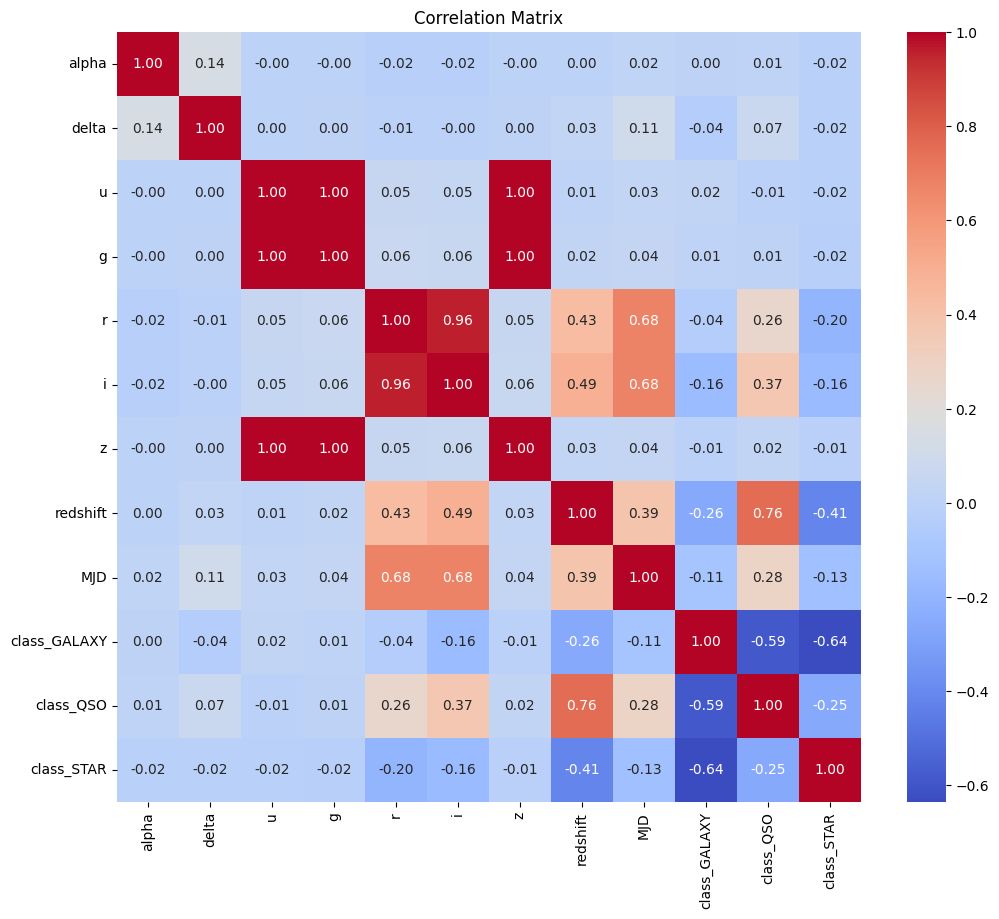

In [118]:
df_classdropped = df_transformed.drop(columns=['class'])
df_classdropped = df_classdropped.convert_dtypes()
df_classdropped = df_classdropped.astype(float) #There was an issue with the conversion to df where datatypes were of type object and the corr matrix appeared empty
corr_matrix = df_classdropped.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

- Previous analyses have highlighted the predictive utility of celestial coordinates, yet their non-linear relationship with the target is not captured by the correlation matrix.
- As for the other attributes, there is a discernible correlation between redshift, MJD, and the class labels, as well as between the photometric filters and the classes.

These observations suggest that both sets of features could be valuable for prediction, with celestial coordinates requiring non-linear modeling to harness their full potential.

### Last preparation steps
We now remove the onehot columns, we encode the target labels and we perform the train test split with stratification and test size 0.2 since we have a considerable number of samples

In [119]:
lb = LabelEncoder()

#not scaled dataframes for visualization
df_y = df_dropped['class']
df_X = df_dropped.drop(['class'],axis=1)

#training and testing data
y = lb.fit_transform(df_y)
X = array_transformed[:, :-4] # dropping all the class features previously used for the correlation matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

## Dimensionality Reduction
Before performing an extensive grid search let's check the relevancy of our features and their impact on the performance of our two classifiers

Text(0, 0.5, 'Performance measure')

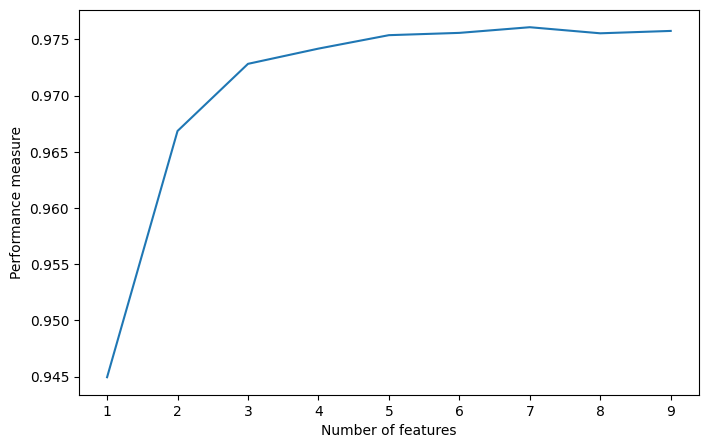

In [130]:
sfs = SFS(XGBClassifier(n_jobs=-1), 
           k_features=1, 
           forward=False,
           cv=3,
           scoring='f1_weighted',
           n_jobs=-1)
sfs.fit(X_train, y_train)

scores_back = sfs.get_metric_dict()
fig = plt.figure(figsize = (8,5))
ax = fig.add_subplot()
ax.plot(list(scores_back.keys()),[v['avg_score'] for v in scores_back.values()])
ax.set_xlabel('Number of features')
ax.set_ylabel('Performance measure')

In [131]:
sfs_settings = sfs.get_metric_dict()
feat_indexes = sfs_settings[7]['feature_idx']
df_X.columns[list(feat_indexes)]

Index(['u', 'g', 'r', 'i', 'z', 'redshift', 'MJD'], dtype='object')

It appears that the celestial coordinates are unnecessary for classification purpose.

I assume this is because if we observe the scatter plot of the classes w.r.t. the celestial coordinates it appears that the only objects in clear separate clusters are star, however they are more easily classified with redshift and light filters

Let's verify if the performance degrades using a Random forest Classifier

In [132]:
rf = RandomForestClassifier(n_jobs=-1)
score = cross_val_score(rf, X_train, y_train, cv = 5, scoring="f1_weighted", verbose=3)
print(np.mean(score))

[CV] END ................................ score: (test=0.978) total time=   7.7s
[CV] END ................................ score: (test=0.980) total time=   7.6s
[CV] END ................................ score: (test=0.979) total time=   8.0s
[CV] END ................................ score: (test=0.977) total time=   7.6s
[CV] END ................................ score: (test=0.979) total time=   8.4s
0.9785712881447137


In [133]:
X = X[:,[2,3,4,5,6,7,8]]
X_train = X_train[:,[2,3,4,5,6,7,8]]
X_test = X_test[:,[2,3,4,5,6,7,8]]

In [134]:
score = cross_val_score(rf, X_train, y_train, cv = 5, scoring="f1_weighted", verbose=3)
print(np.mean(score))

[CV] END ................................ score: (test=0.977) total time=   5.1s
[CV] END ................................ score: (test=0.980) total time=   5.4s
[CV] END ................................ score: (test=0.978) total time=   4.9s
[CV] END ................................ score: (test=0.976) total time=   5.2s
[CV] END ................................ score: (test=0.979) total time=   5.3s
0.9781474623785288


Also RandomForest peformances seems to be unaffected by the loss of coordinates and r light filter

In [136]:
df_X = df_X[['u', 'g', 'r', 'i', 'z', 'redshift', 'MJD']]
df_X

,u,g,r,i,z,redshift,MJD
0,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794,56354.0
1,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136,58158.0
2,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195,55592.0
3,22.13682,23.77656,NaN,20.50454,19.25010,0.932346,58039.0
4,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123,56187.0
...,...,...,...,...,...,...,...
104995,22.16759,22.97586,21.90404,21.30548,20.73569,0.000000,57749.0
104996,22.69118,22.38628,20.45003,19.75759,19.41526,0.404895,56934.0
104997,21.16916,19.26997,18.20428,17.69034,17.35221,0.143366,54535.0
104998,25.35039,21.63757,19.91386,19.07254,18.62482,0.455040,56368.0


# Looking for a model
To find the best model for this classification we will try different combinations of the sequent elements:

- Samplers, to take into account the imbalance beetween the three classes
- Dimensionality reduction techniques, here the main purpose is not to reduce the number of features since 6 is manageable for most models but to reduce redundancy and perform feature rotation
- Predictors, Some data features like celestial coordinates suggest non-linear relationship, so I will exclude linear predictors.

In [137]:
model_pipeline = IMBPipeline([
    ('sampler', SMOTE()),
    ('dim_reduction', PCA()),
    ('classifier', Perceptron())
])

model_pipeline.fit(X_train,y_train)

Pipeline(steps=[('sampler', SMOTE()), ('dim_reduction', PCA()),
                ('classifier', Perceptron())])

## Configurations

Different elements will be tried in a randomized search, the elements involved are:

#### Sampler Configurations

1. **No Sampling**: This option indicates that no sampling method is applied in the pipeline.

2. **SMOTE (Synthetic Minority Over-sampling Technique)**: An advanced oversampling technique that generates synthetic samples for the minority class by interpolating new points between existing ones.

3. **BorderlineSMOTE**: An extension of SMOTE, this method specifically targets minority class samples that are near the borderline, potentially improving model sensitivity to the class boundary.

4. **ADASYN (Adaptive Synthetic Sampling)**: Similar to SMOTE, but places more emphasis on generating samples next to the minority class samples that are hard to learn, aiming to adaptively balance the class distribution.

5. **Random Over Sampler**: A simple oversampling approach that randomly replicates samples from the minority class to achieve a balanced dataset.

#### Dimension Reduction Configurations

1. **No Dimension Reduction**: Indicates the absence of any dimensionality reduction technique in the model.

2. **PCA (Principal Component Analysis)**: A statistical procedure that utilizes orthogonal transformation to convert a set of possibly correlated variables into a set of linearly uncorrelated variables called principal components.

#### Classifiers Configurations

1. **XGBClassifier (Extreme Gradient Boosting)**: A highly efficient and scalable implementation of gradient boosting framework, known for its performance and speed in machine learning competitions.

2. **SVC (Support Vector Classifier)**: A powerful, versatile machine learning algorithm, especially effective in high dimensional spaces, which works well for both linear and non-linear decision boundaries.

3. **RandomForestClassifier**: An ensemble learning method that constructs multiple decision trees during training and outputs the mode of the classes or mean prediction of the individual trees, offering robustness and accuracy.

In [138]:
sampler_configs = [
    {
        'sampler':[None] # The element is bypassed
    },
    {
        'sampler':[SMOTE(n_jobs=-1)],
        'sampler__sampling_strategy':['not majority', 'all'],
        'sampler__k_neighbors':[3,5,7]
    },
    {
        'sampler':[BorderlineSMOTE(n_jobs=-1)],
        'sampler__sampling_strategy':['not majority', 'all'],
        'sampler__kind': ['borderline-1', 'borderline-2']
    },
    {
        'sampler':[ADASYN(n_jobs=-1)],
        'sampler__sampling_strategy':['not majority', 'all'],
        'sampler__n_neighbors':[3,5,7]
    },
    {
        'sampler':[RandomOverSampler()],
        'sampler__sampling_strategy':['not majority', 'all']
    },
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()] # all components
    }
]

classifier_configs_XGB = [
    {
        'classifier' : [XGBClassifier(n_jobs=-1)],
        'classifier__n_estimators' : [50, 100, 150, 200],
        'classifier__learning_rate' : [0.01, 0.05, 0.1, 0.2],
        'classifier__max_depth' : [3,5,7,9],
        'classifier__gamma': [0, 0.1, 0.2]
    }]

classifier_configs_SVC = [
    {
        'classifier': [SVC()],
        'classifier__kernel': ['rbf', 'poly'],
        'classifier__gamma': ['scale', 'auto', 0.01, 0.1, 1],
        'classifier__C': [0.1, 1, 10, 50]
    }]

classifier_configs_RF = [
    {
        'classifier' : [RandomForestClassifier(n_jobs=-1)],
        'classifier__n_estimators' : [100, 200, 300],
        'classifier__max_features': ['auto', 'sqrt', 'log2'],
        'classifier__max_depth': [10, 20, 30, None]
    }]

### Targeted testing
I will evaluate the different combinations dividing them by classifier. This helps in managing efficently the available resources and inspecting possible problems due to unefficent configurations individually

In [139]:
all_configs_XGB = [dict(itertools.chain(*(e.items() 
for e in configuration))) 
for configuration in 
itertools.product(sampler_configs,dim_reduction_configs,classifier_configs_XGB)]

all_configs_SVC = [dict(itertools.chain(*(e.items() 
for e in configuration))) 
for configuration in 
itertools.product(sampler_configs,dim_reduction_configs,classifier_configs_SVC)]

all_configs_RF = [dict(itertools.chain(*(e.items() 
for e in configuration))) 
for configuration in 
itertools.product(sampler_configs,dim_reduction_configs,classifier_configs_RF)]

We will employ the weighted F1 score as our chosen metric for cross-validation. This choice ensures that our model remains robust even when dealing with underrepresented classes, preventing any potential bias.

In [141]:
rs_XGB = RandomizedSearchCV(
    model_pipeline,
    param_distributions=all_configs_XGB,
    n_iter=len(all_configs_XGB)*8,
    scoring='f1_weighted',
    cv=4,
    n_jobs=-1,
    verbose=3
)

rs_SVC = RandomizedSearchCV(
    model_pipeline,
    param_distributions=all_configs_SVC,
    n_iter=len(all_configs_XGB)//2,
    scoring='f1_weighted',
    cv=2,
    n_jobs=-1,
    verbose=3
)

rs_RF = RandomizedSearchCV(
    model_pipeline,
    param_distributions=all_configs_RF,
    n_iter=len(all_configs_RF)*3,
    scoring='f1_weighted',
    cv=3,
    n_jobs=-1,
    verbose=3
)

In [142]:
scores_XGB = cross_validate(rs_XGB, X_train, y_train, scoring="f1_weighted", cv=5, return_estimator=True, verbose=3)

Fitting 4 folds for each of 80 candidates, totalling 320 fits
[CV] END ......................................., score=0.975 total time= 4.9min
Fitting 4 folds for each of 80 candidates, totalling 320 fits
[CV] END ......................................., score=0.979 total time= 4.9min
Fitting 4 folds for each of 80 candidates, totalling 320 fits
[CV] END ......................................., score=0.976 total time= 5.4min
Fitting 4 folds for each of 80 candidates, totalling 320 fits
[CV] END ......................................., score=0.973 total time= 4.5min
Fitting 4 folds for each of 80 candidates, totalling 320 fits
[CV] END ......................................., score=0.977 total time= 4.7min


In [143]:
scores_SVC = cross_validate(rs_SVC, X_train, y_train, scoring="f1_weighted", cv=5, return_estimator=True, verbose=3)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END ......................................., score=0.970 total time= 4.9min
Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END ......................................., score=0.971 total time= 5.3min
Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END ......................................., score=0.944 total time= 4.6min
Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END ......................................., score=0.968 total time= 4.1min
Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END ......................................., score=0.963 total time= 5.2min


In [144]:
scores_RF = cross_validate(rs_RF, X_train, y_train, scoring="f1_weighted", cv=5, return_estimator=True, verbose=3)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END ......................................., score=0.978 total time=10.3min
Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END ......................................., score=0.978 total time= 9.0min
Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END ......................................., score=0.978 total time=13.6min
Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END ......................................., score=0.975 total time= 9.1min
Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END ......................................., score=0.980 total time=13.7min


In [145]:
all_scores = [scores_XGB,scores_SVC,scores_RF]
dump(all_scores, 'all_scores.joblib')

# all_scores = load("all_scores.joblib")

['all_scores.joblib']

### Initial Results
Several models have been tried in the cross validation, we observe high f1 weighted score for most of them. My next step will be to pick the best combination for each type of predictor to build in the end an ensemble model

In [146]:
for score in all_scores:
    for index, estimator in enumerate(score['estimator']):
        print(estimator.best_estimator_.get_params()['sampler'])
        print(estimator.best_estimator_.get_params()['dim_reduction'])
        print(estimator.best_estimator_.get_params()['classifier'].__class__.__name__,estimator.best_estimator_.get_params()['classifier'].get_params())
        print(score['test_score'][index])
        print('-'*30)
    print("\n")

RandomOverSampler(sampling_strategy='all')
None
XGBClassifier {'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.1, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 7, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 200, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
0.9746310805100654
----------------------------

To pick a configuration I assess the performances and overfitting using the train and test set

In [147]:
# XGB configurations
for estimator in scores_XGB['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train, average="weighted")
    f1_test = f1_score(y_test, pred_test, average="weighted")
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:0.9878684126742348, F1 on test set:0.9758530963993428
F1 on training set:0.9839318121591385, F1 on test set:0.9764893532133435
F1 on training set:0.995677796331855, F1 on test set:0.9761578222361964
F1 on training set:0.9886845691156912, F1 on test set:0.9761984564234172
F1 on training set:0.9890250383981631, F1 on test set:0.9759337709898984


Choice: 2nd model

F1: 0.984/0.976

In [148]:
# SVC configurations
for estimator in scores_SVC['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train, average="weighted")
    f1_test = f1_score(y_test, pred_test, average="weighted")
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:0.9722685546898489, F1 on test set:0.9706051998270597
F1 on training set:0.9727685966594493, F1 on test set:0.9704477827620352
F1 on training set:0.9481326013764868, F1 on test set:0.9471235828198271
F1 on training set:0.9714780725217984, F1 on test set:0.9718141249049229
F1 on training set:0.9638767367144639, F1 on test set:0.9650770252781793


Choice: 4th model

F1: 0.971/0.972

In [149]:
# RF configurations
for estimator in scores_RF['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train, average="weighted")
    f1_test = f1_score(y_test, pred_test, average="weighted")
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:1.0, F1 on test set:0.9794791906784076
F1 on training set:1.0, F1 on test set:0.9771786529292689
F1 on training set:1.0, F1 on test set:0.9791226972037211
F1 on training set:1.0, F1 on test set:0.979431550826288
F1 on training set:1.0, F1 on test set:0.9793717019019754


Choice: 1st model

F1 1.0/0.979

In [150]:
best_XGB = scores_XGB["estimator"][1].best_estimator_ # 
best_SVC = scores_SVC["estimator"][3].best_estimator_
best_RF = scores_RF["estimator"][0].best_estimator_

best_models = [best_XGB, best_SVC, best_RF]
dump(best_models, 'best_models.joblib')

best_models = load("best_models.joblib")

for model in best_models: 
    print(model.get_params()['sampler'])
    print(model.get_params()['dim_reduction'])
    print(model.get_params()['classifier'].__class__.__name__),
    print(model.get_params()['classifier'].get_params())
    print("-"*10)

None
None
XGBClassifier
{'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.2, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 7, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 200, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
----------
None
None
SVC
{'C': 10, 'break_ties': False, 'cache_size': 200, 'class_wei

## Best models optimization

I'll maintain only the XGB and Random Forest models.
The reason behind that are:
- Some particular new hyperparameters settings of the algorithm, when fitted on our 80k samples dataset, seems to take an indefinite amount of time which make the randomized useless or indefinitely long (more than 4 hours for 60 fits with n_jobs=-1)
- Usability, even I succeed in finding the best hyperparameters, the time for predicting new values could be of several minutes. Given the similar F1 score of XGB and Random Forest, they would probably be preferred in a real word scenario since they only take a couple of seconds to fit or perform a prediction.

Unluckily, with this decision, we are losing one particular feature of the SVC model: the almost unexistence of overfitting

I will now add more possible configuration for the model with a preference for the one that proved to be efficent.

The use of beta distributions will help in focusing the possible values around the desired ones

In [153]:
classifier_opt_configs_XGB = { 
    "learning_rate": beta(a=2, b=10),
    "estimators" : range(50,200),
    "max_depth": range(3,21),
    "gamma": beta(a=1, b=30),
    "colsample_bytree": beta(a=2, b=4),
    "reg_alpha": [0.01, 0.05, 0.1, 0.5, 1, 10, 100],
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100]
}

classifier_opt_configs_RF = { 
    'sampler': [RandomOverSampler(sampling_strategy="all")],
    'dim_reduction': [None],
    'classifier': [RandomForestClassifier(n_jobs=-1)],
    'classifier__n_estimators' : list(range(100,800)),
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__max_depth': list(range(5,100)) + [None]*20,
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__min_samples_split': [2, 3, 4, 5, 10]
}

In [154]:
rs_opt_XGB = RandomizedSearchCV(
    estimator = XGBClassifier(),
    param_distributions=classifier_opt_configs_XGB,
    n_iter=80,
    scoring='f1_weighted',
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3),
    n_jobs=-1,
    verbose=3
)

rs_opt_RF = RandomizedSearchCV(
    estimator = model_pipeline,
    param_distributions=classifier_opt_configs_RF,
    n_iter=40,
    scoring='f1_weighted',
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2),
    n_jobs=-1,
    verbose=3
)

In [155]:
rs_opt_XGB.fit(X_train, y_train)
dump(rs_opt_XGB,"rs_opt_XGB.joblib")

Fitting 15 folds for each of 80 candidates, totalling 1200 fits


['rs_opt_XGB.joblib']

In [156]:
rs_opt_RF.fit(X_train, y_train)
dump(rs_opt_RF,"rs_opt_RF.joblib")

Fitting 6 folds for each of 40 candidates, totalling 240 fits


['rs_opt_RF.joblib']

In [158]:
rs_opt_XGB = load("rs_opt_XGB.joblib")
rs_opt_RF = load("rs_opt_RF.joblib")

opt_models = [rs_opt_XGB, rs_opt_RF]

for model in opt_models:
    print(model.best_params_)
    pred_train = model.best_estimator_.predict(X_train)
    pred_test = model.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train, average="weighted")
    f1_test = f1_score(y_test, pred_test, average="weighted")
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')
    print(10 * "-")

{'colsample_bytree': 0.6958694266867349, 'estimators': 102, 'gamma': 0.013841041387682046, 'learning_rate': 0.1377220370399293, 'max_depth': 10, 'reg_alpha': 0.01, 'reg_lambda': 1}
F1 on training set:0.9937888887520858, F1 on test set:0.9772363897496692
----------
{'sampler': RandomOverSampler(sampling_strategy='all'), 'dim_reduction': None, 'classifier__n_estimators': 487, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 1, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 25, 'classifier': RandomForestClassifier(n_jobs=-1)}
F1 on training set:0.9999749994387391, F1 on test set:0.9792289420874067
----------


The improvement is very slight however

## Ensembling these two classifiers
I will try an ensembling of the two classifier with soft voting since the classes provide the predict_proba method

In [159]:
soft_clf = VotingClassifier(
    estimators=[('XGB', rs_opt_XGB.best_estimator_), ('RF', rs_opt_RF.best_estimator_)],
    voting='soft'
)

print('5-fold cross validation:\n')
scores = cross_val_score(estimator=soft_clf, X=X_train, y=y_train, cv=5, scoring="f1_weighted", verbose=3)
print(f'F1: {scores.mean():.3f} ' , f'(+/- {scores.std():.3f}) [soft voting]')

5-fold cross validation:

[CV] END ................................ score: (test=0.978) total time=  36.9s
[CV] END ................................ score: (test=0.979) total time=  36.8s
[CV] END ................................ score: (test=0.978) total time=  38.9s
[CV] END ................................ score: (test=0.975) total time=  41.2s
[CV] END ................................ score: (test=0.980) total time=  41.0s
F1: 0.978  (+/- 0.002) [soft voting]


In [160]:
soft_clf.fit(X_train, y_train)

pred_train = soft_clf.predict(X_train)
pred_test = soft_clf.predict(X_test)

f1_train = f1_score(y_train, pred_train, average="weighted")
f1_test = f1_score(y_test, pred_test, average="weighted")

print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')
print(10 * "-")

F1 on training set:0.9988369185136929, F1 on test set:0.9777033484473954
----------


# Discussion of the results

We've obtained high performances with random forest, XGB and an ensebling of them. Now let's delve deeper into how they are able to classify the individual classes and let's look for overfitting

## Confusion Matrix
The confusion matrix will help us to inspect which classes have been misclassified the most

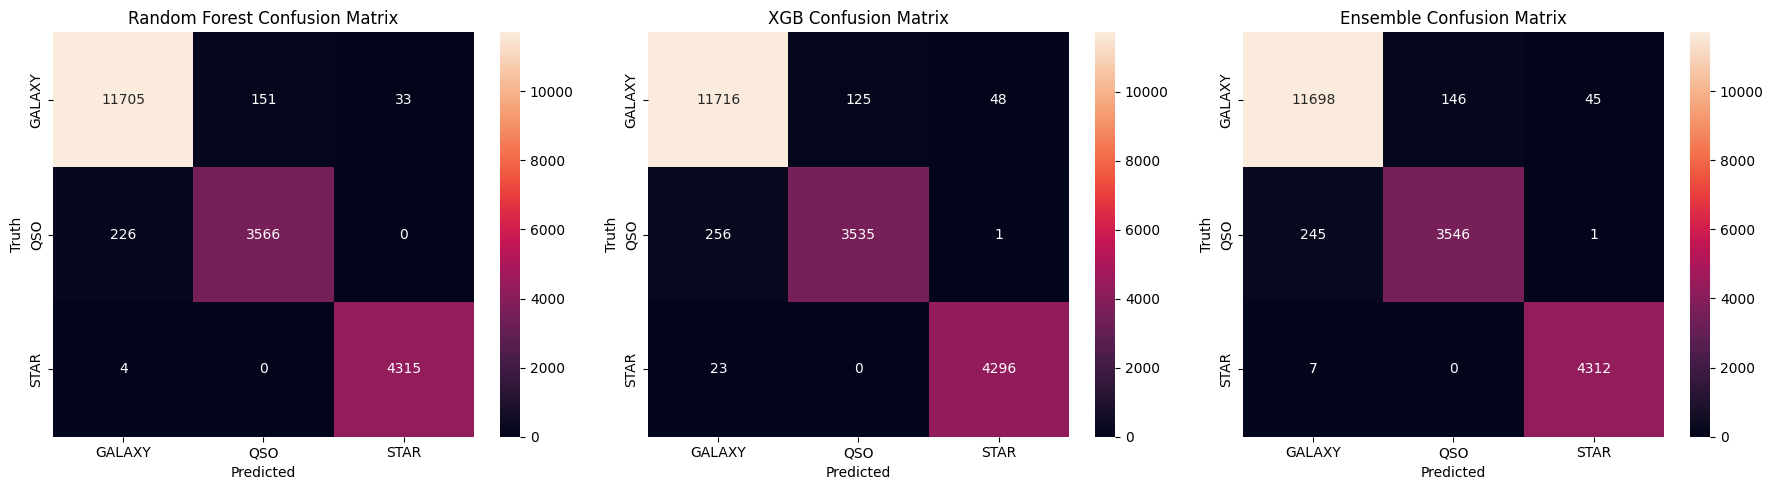

In [163]:
y_pred_rf  = rs_opt_RF.best_estimator_.predict(X_test)
y_pred_XGB = rs_opt_XGB.best_estimator_.predict(X_test)
y_pred_ens = soft_clf.predict(X_test)

# Creating the confusion matrix
cm_rf  = confusion_matrix(y_test, y_pred_rf)
cm_XGB = confusion_matrix(y_test, y_pred_XGB)
cm_ens = confusion_matrix(y_test, y_pred_ens)

classes = lb.inverse_transform([0,1,2])

plt.figure(figsize=(18, 5))

# Random Forest Confusion Matrix
plt.subplot(1, 3, 1)
sns.heatmap(cm_rf, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# XGB Confusion Matrix
plt.subplot(1, 3, 2)
sns.heatmap(cm_XGB, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.title('XGB Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Ensemble Confusion Matrix
plt.subplot(1, 3, 3)
sns.heatmap(cm_ens, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
plt.title('Ensemble Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Adjust the layout
plt.tight_layout()
plt.show()

The three confusion matrixes tell us different aspects about our models:
- Among the classes Stars are the easiest to classify, this is highly probably due to their closeness to earth, which results in close to zero redshift value
- The hardest class to classify is QSO, it's often misclassified as Galaxy, this reflects the difficulty into identifying differences beetween very far objects in the sky

### Let's have a better look to the scores

In [164]:
report = classification_report(y_pred_rf, y_test, target_names=classes)
print("Random forest\n",report)

Random forest
               precision    recall  f1-score   support

      GALAXY       0.98      0.98      0.98     11935
         QSO       0.94      0.96      0.95      3717
        STAR       1.00      0.99      1.00      4348

    accuracy                           0.98     20000
   macro avg       0.97      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000



In [165]:
report = classification_report(y_pred_XGB, y_test, target_names=classes)
print("XGB\n",report)

XGB
               precision    recall  f1-score   support

      GALAXY       0.99      0.98      0.98     11995
         QSO       0.93      0.97      0.95      3660
        STAR       0.99      0.99      0.99      4345

    accuracy                           0.98     20000
   macro avg       0.97      0.98      0.97     20000
weighted avg       0.98      0.98      0.98     20000



In [166]:
report = classification_report(y_pred_ens, y_test, target_names=classes)
print("Ensemble\n",report)

Ensemble
               precision    recall  f1-score   support

      GALAXY       0.98      0.98      0.98     11950
         QSO       0.94      0.96      0.95      3692
        STAR       1.00      0.99      0.99      4358

    accuracy                           0.98     20000
   macro avg       0.97      0.98      0.97     20000
weighted avg       0.98      0.98      0.98     20000



It seems that the three models behave very similarly, hence I will continue assessing the performances only of XGBoost, which is the fastest one.

In [167]:
final_model = rs_opt_XGB.best_estimator_

## ROC-AUC for Each Class
ROC and AUC help us assess how the model performs in correctly classifying the correct label. The more the curve looks like a step function the more the model is able to identify the class

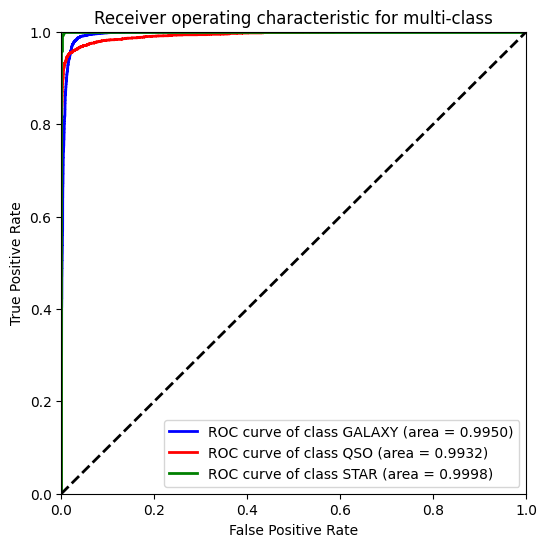

In [168]:
# Binarize the output labels for a One-vs-Rest approach
y_test_binarized = label_binarize(y_test, classes=[0,1,2])
y_scores = final_model.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC and AUC for each class
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6, 6))

colors = ['blue', 'red', 'green']
for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.4f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()

The ROC curves for the classes GALAXY, QSO, and STAR are all very close to the upper left corner, indicating excellent model performance with high true positive rates and low false positive rates. The AUC values are all exceptionally high (>0.99), suggesting that the model is highly effective at classifying all three categories.

As noted before stars appear to be the easiest object to recognize

## Learning Curve
The learnign Curve shows us how the model behave as we increment the train size


In [169]:
train_sizes, train_scores, test_scores = learning_curve(final_model,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 5,
                                                       n_jobs = -1,
                                                       scoring = 'f1_weighted',
                                                       shuffle = True)

(0.95, 1.02)

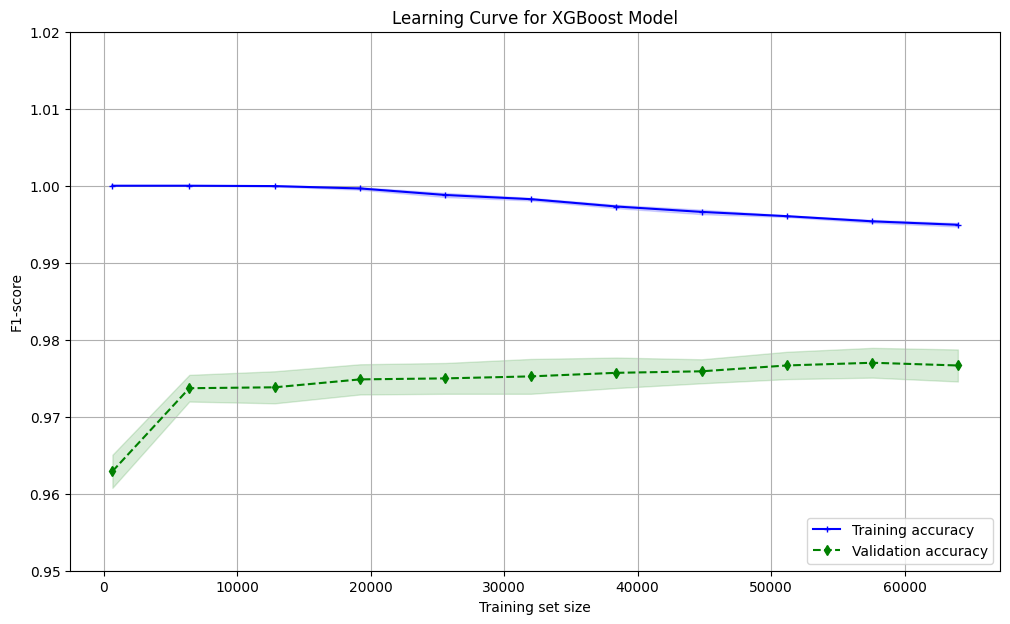

In [170]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('F1-score')
ax.set_title('Learning Curve for XGBoost Model')
ax.legend(loc='lower right')
ax.set_ylim([0.95, 1.02])

After 6000 samples the model starts to plateau and increasing very slowly. Some overfitting is also present

## Validation curve
The validation curve helps analyzing how changing the hyperparamter **n_estimators** can result in overfitting

In [171]:
range_n_estimators = [1, 10, 25, 50, 100, 137, 150, 200, 250, 300]
train_scores, test_scores = validation_curve(
    final_model,
    X=X_train, 
    y=y_train, 
    param_range = range_n_estimators, 
    param_name='n_estimators',
    cv=5, 
    n_jobs=-1, 
    scoring='f1_weighted'
)

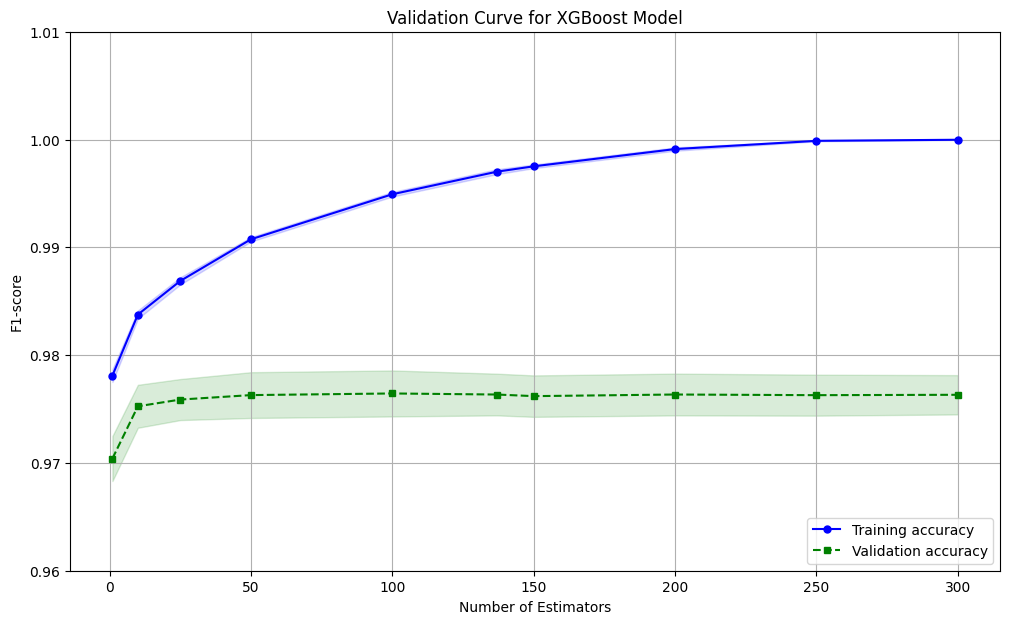

In [172]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot()

# Plot training scores
ax.plot(range_n_estimators,
        train_mean,
        color='blue',
        marker='o',
        markersize=5,
        label='Training accuracy')

ax.fill_between(range_n_estimators,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.15,
                color='blue')

# Plot validation scores
ax.plot(range_n_estimators,
        test_mean,
        color='green',
        linestyle='--',
        marker='s',
        markersize=5,
        label='Validation accuracy')

ax.fill_between(range_n_estimators,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.15, color='green')

# Set labels and title
ax.set_xlabel('Number of Estimators')
ax.set_ylabel('F1-score')
ax.set_title('Validation Curve for XGBoost Model')
ax.legend(loc='lower right')

ax.set_ylim([0.96, 1.01])
ax.grid()

plt.show()

We observe that as we add estimators the model overfitting increases, a good value for n_estimators would then be close to 50, that is when the validation curve stops increasing.
Modifyng the hyperparameters of the model could further reduce overfitting

## Feature importance
Using permutation importance we can assess how the features influence the model performance

In [174]:
r = permutation_importance(final_model, X_train, y_train,
                           n_repeats=3,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{df_X.columns[i]:<8} "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

redshift 0.499 +/- 0.001
g        0.025 +/- 0.000
u        0.023 +/- 0.001
z        0.019 +/- 0.000
i        0.015 +/- 0.000
MJD      0.013 +/- 0.000
r        0.009 +/- 0.000


## Last Considerations
### Modified Julian Date (MJD)
Beetween the features we included the Modified Julian Date (MJD), which could introduce biases due to several reasons:

- Changes in observation equipment or data collection methods over time that correlate with MJD.
- Evolution of data preprocessing techniques that may impact the quality of data linked to MJD.
- Seasonal or temporal astronomical phenomena that could be captured by MJD, unrelated to the intrinsic properties being modeled.

However, there are also some reasons to maintain it:

- MJD can be crucial for identifying and leveraging patterns in time-sensitive astronomical events. For example, the appearance or behavior of certain celestial objects might vary predictably over time.

In a real world scenario I would exclude this feature since the model would probably be used to classify new observations. This would mean presenting new values of MJD to a model overfitted on the old ones. Without MJD, we would have a time-independent model, which has its own advantages and disadvantages, capable of assessing the classes solely based on the intrinsic properties of the stellar objects.